# NN Домашнее задание №4

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertModel

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tqdm import tqdm

## Чтение данных

In [ ]:
df_train = pd.read_csv('/kaggle/input/nn-text/train.csv')
df_test = pd.read_csv('/kaggle/input/nn-text/test.csv')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data.iloc[idx, 1]
        rating = self.data.iloc[idx, 2]
        encode_text = tokenizer.encode_plus(
            sentence,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            max_length=512,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'ids': encode_text['input_ids'],
            'mask': encode_text['attention_mask'],
            'target': torch.tensor(rating, dtype=torch.long)
        }

In [ ]:
train_dataset = TextDataset(df_train, tokenizer)

## Получение эмбедингов

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
model_bert = model_bert.to(device)

In [ ]:
train_embeddings = []
train_labels = []
for i in tqdm(range(len(train_dataset))):
    outputs = model_bert(train_dataset[i]['ids'].to(device), attention_mask=train_dataset[i]['mask'].to(device)).last_hidden_state[:, 0, :].cpu().detach().numpy()
    train_embeddings.append(outputs)
    train_labels.append(int(train_dataset[i]['target']))

train_embeddings = np.squeeze(np.array(train_embeddings))
train_labels = np.array(train_labels)

  0%|          | 0/14343 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/token

## Построенние классификатора

In [ ]:
model_clf = LogisticRegression()
model_clf.fit(train_embeddings, train_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
train_pred = model_clf.predict(train_embeddings)
print('Training accuracy:', accuracy_score(train_labels, train_pred))

Training accuracy: 0.6214878337865161


## Построение эмбедингов для теста

In [ ]:
df_test['Rating'] = df_test.iloc[:,0]

In [ ]:
test_dataset = TextDataset(df_test, tokenizer)

In [ ]:
test_embeds = []
for i in tqdm(range(len(test_dataset))):
    outputs = model_bert(test_dataset[i]['ids'].to(device), attention_mask=test_dataset[i]['mask'].to(device)).last_hidden_state[:, 0, :].cpu().detach().numpy()
    test_embeds.append(outputs)

  0%|          | 0/6148 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 6148/6148 [04:16<00:00, 23.98it/s]


In [ ]:
test_embeds = np.squeeze(np.array(test_embeds))

## Предсказания на тесте

In [ ]:
submission = pd.read_csv('/kaggle/input/nn-text/sample_submission.csv')
submission["Rating"] = model_clf.predict(test_embeds)
submission.to_csv("embedding_model_with_LogReg.csv", index=False)

## Результат сабмита

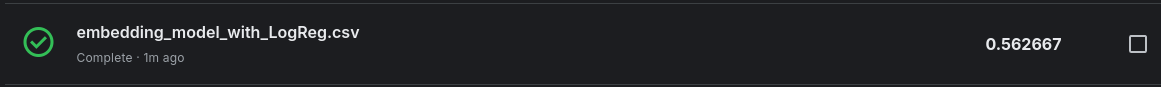